In [1]:
import pandas as pd
import requests
from Bio.KEGG import Enzyme
import matplotlib
import io
import time
import pickle
import re
from rich.progress import Progress
from rdkit import Chem
from collections import Counter
import rdkit.Chem as Chem
from rdkit.Chem import BRICS,Recap, rdFMCS
from rdkit.Chem import Draw

import pickle
import os
import math
import numpy as np
from math import isnan

import argparse
import snakemake

In [2]:
def get_parity_score(mol1, mol2, print_structures = False, ringmatches = False,returnmcs = False, timeout = 300):
    # Get the MCS of the two molecules
    mcs_result = rdFMCS.FindMCS(
        [mol1, mol2], 
        matchValences=False,
        ringMatchesRingOnly= ringmatches,
        atomCompare=rdFMCS.AtomCompare.CompareAny, 
        bondCompare=rdFMCS.BondCompare.CompareAny, timeout = timeout)
    if mcs_result.canceled:
        cancelled = True
    else:
        cancelled = False
    # Convert the SMARTS string from the MCS result into a molecule
    mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)

    # Map the MCS back onto the original molecules and get the atom indices
    mol1_match = mol1.GetSubstructMatch(mcs_mol)
    mol2_match = mol2.GetSubstructMatch(mcs_mol)
    
    if print_structures:
        # Draw the molecules and the MCS
        Draw.MolToMPL(mol1, size=(200,200), kekulize=True, title='Molecule 1')
        Draw.MolToMPL(mol2, size=(200,200), kekulize=True, title='Molecule 2')
        Draw.MolToMPL(mcs_mol, size=(200,200), kekulize=True, title='MCS')
    # Compare the atom types at each matched position
    Nsim = 0
    for idx1, idx2 in zip(mol1_match, mol2_match):
        atom1 = mol1.GetAtomWithIdx(idx1)
        atom2 = mol2.GetAtomWithIdx(idx2)
        if atom1.GetAtomicNum() == atom2.GetAtomicNum():
            Nsim += 1

    # Compute PARITY similarity score
    NB = mol1.GetNumAtoms()
    NC = mol2.GetNumAtoms()
    score = Nsim / (NB + NC - Nsim)
    if returnmcs:
        return score, cancelled, mcs_mol
    else:
        return score, cancelled

In [3]:
all_chem_descriptors_inchi_unique_pairs = pd.read_pickle("parity_calcs/all_chem_descriptors_inchi_unique_pairs.pkl")

In [4]:
final_kegg_compound_reaction_enzyme_df = pd.read_pickle("parity_calcs/final_kegg_compound_reaction_enzyme_df.pkl")

In [19]:
final_kegg_compound_reaction_enzyme_df.loc[final_kegg_compound_reaction_enzyme_df.compound_id == "4799"].T

,146143,146149
pdb_entry,6.1.1.11,6.1.1.11
matched_entry,6.1.1.11,6.1.1.11
matched_name,serine---tRNA ligase,serine---tRNA ligase
EC_substrates,"[ATP [CPD:C00002], L-serine [CPD:C00065], tRNA...","[ATP [CPD:C00002], L-serine [CPD:C00065], tRNA..."
EC_products,"[AMP [CPD:C00020], diphosphate [CPD:C00013], L...","[AMP [CPD:C00020], diphosphate [CPD:C00013], L..."
EC_dbxrefs,"[(ExplorEnz - The Enzyme Database, [6.1.1.11])...","[(ExplorEnz - The Enzyme Database, [6.1.1.11])..."
EC_reactions,R03662,R03662
EC_substrate_codes,"[C00002, C00065, C01650]","[C00002, C00065, C01650]"
EC_product_codes,"[C00020, C00013, C02553]","[C00020, C00013, C02553]"
reaction_id,R03662,R03662


In [49]:
import random
# Set random seeds for reproducibility
random.seed(10001)
numpy_seed = 301

# Number of ligands to sample
num_samples = 1000

# Initialize a list to store the parity scores
parity_scores = []

# Sample and calculate parity scores - think about how to do this to build results into a dataframe.
for _ in range(num_samples):
    # Randomly sample a ligand from all_chem_descriptors
    mol1 = Chem.inchi.MolFromInchi(all_chem_descriptors_inchi_unique_pairs.sample(n=1).descriptor.values[0])

    # Randomly sample a ligand from final_kegg_compound_reaction_enzyme_df
    mol2 = final_kegg_compound_reaction_enzyme_df.loc[final_kegg_compound_reaction_enzyme_df.mol.isna() == False].sample(n=1).mol.values[0]

    # Calculate the parity score
    score, finished = get_parity_score(mol1, mol2, print_structures=False, ringmatches=False, returnmcs=False, timeout=300)

    # Append the score to the list
    parity_scores.append(score)

[20:52:16] WARNING:  (Metal compound)Disconnected:  Problems/mismatches: Mobile-H( Charge(s): Do not match)

[20:52:16] WARNING:  (Metal compound)Disconnected:  Problems/mismatches: Mobile-H( Charge(s): Do not match)

[20:53:57] WARNING:  (Metal compound)Disconnected:  Problems/mismatches: Mobile-H( Charge(s): Do not match)

[20:54:09] WARNING:  (Metal compound)Disconnected:  Problems/mismatches: Mobile-H( Charge(s): Do not match)

[20:59:21] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)

[20:59:28] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)

[20:59:30] WARNING:  (Metal compound)Disconnected:  Problems/mismatches: Mobile-H( Charge(s): Do not match)

[20:59:37] WARNING:  (Metal compound)Disconnected:  Problems/mismatches: Mobile-H( Charge(s): Do not match)

[21:00:40] WARNING:  (Metal compound)Disconnected:  Problems/mismatches: Mobile-H( Charge(s): Do not m

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [52]:
parity_scores_2 = [item[0] for item in parity_scores]

In [154]:
pd.to_pickle(parity_scores_2, "parity_scores_random.pkl")

In [5]:
parity_scores_2 = pd.read_pickle("parity_scores_random.pkl")

In [6]:
len([item for item in parity_scores_2 if item > 0.6])

12

In [7]:
# Calculate the average parity score
average_score = sum(parity_scores_2) / num_samples

# Print the average score
print(f"Average Parity Score: {average_score}")

NameError: name 'num_samples' is not defined

In [44]:
#now load a dataframe of cognate ligand pairs to score.

(0.09615384615384616, False)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

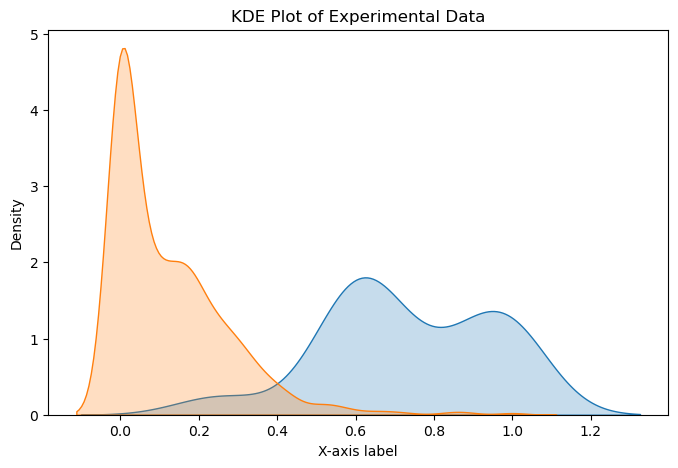

In [23]:
plt.figure(figsize=(8, 5))
sns.kdeplot(cognate_scores, fill=True)
sns.kdeplot(parity_scores_2, fill=True)
plt.xlabel('X-axis label')
plt.ylabel('Density')
plt.title('KDE Plot of Experimental Data')
plt.show()

In [10]:
cognate_ligand_pairs = pd.read_csv("cognate_ligand_pairs.csv")

In [22]:
cognate_ligand_pairs

,pdb_ligand,kegg_ligand,note
0,5h1y_2,C00009,NaN
1,1dvr_2,C00002,NaN
2,5cg2_2,C00003,NaN
3,1gp6_5,C21418,NaN
4,4hn2_2,C00002,ANP
5,4hn2_3,C20690,NaN
6,1rx0_3,C01182,NaN
7,2vhd_2,C00126,NaN
8,7v1i_4,C00201,NTP
9,5cns_3,C04232,CTP


In [11]:
cognate_scores = []
for _, row in cognate_ligand_pairs.iterrows():
    mol1 = Chem.MolFromInchi(all_chem_descriptors_inchi_unique_pairs.loc[all_chem_descriptors_inchi_unique_pairs.ligand_entity_id == row.pdb_ligand].descriptor.values[0])
    mol2 = final_kegg_compound_reaction_enzyme_df.loc[final_kegg_compound_reaction_enzyme_df.compound_id.astype("str") == row.kegg_ligand].mol.values[0]
    score, finished = get_parity_score(mol1, mol2, print_structures=False, ringmatches=False, returnmcs=False, timeout=300)
    cognate_scores.append(score)

In [12]:
sum(cognate_scores) / len(cognate_scores)

0.7320105377668812

In [16]:
!pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/8f/87/5969092159207f583481ad80a03f09e2d4af1ebd197f4530ca4e906c947e/scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.7 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)


In [13]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

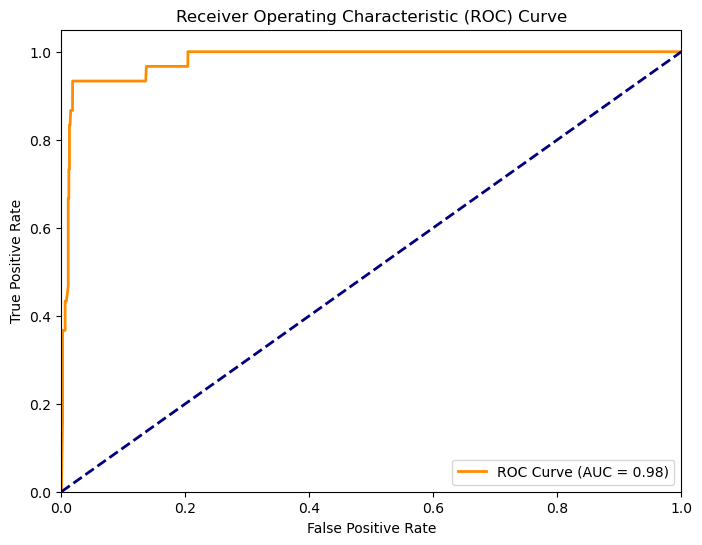

Youden Index: 0.92 (Threshold: 0.55)


In [16]:
positive_scores = cognate_scores

negative_scores = parity_scores_2

fpr, tpr, thresholds = roc_curve([1] * len(positive_scores) + [0] * len(negative_scores), positive_scores + negative_scores)

roc_auc = roc_auc_score([1] * len(positive_scores) + [0] * len(negative_scores), positive_scores + negative_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


youden_threshold = thresholds[np.argmax(tpr - fpr)]
youden_index = np.max(tpr - fpr)
print(f'Youden Index: {youden_index:.2f} (Threshold: {youden_threshold:.2f})')